# Bavarian_Game_ex3_Yuzhe_Zhidong

## Task 1

**(1) Feedback Visualization.**  
To implement the three required **feedback types** — **`trajectory`**, **`endpos`**, and **`rl`** — we reused the trial history stored by the game loop: `last_trajectory` and `trial_positions`. After each trial ends, the program updates these buffers, and `draw_feedback()` renders the corresponding feedback using pygame drawing primitives.


```python
    ...
def draw_feedback():
    """Display feedback based on the feedback type.
    
    - trajectory: Show full trajectory of previous trial
    - endpos: Show only end position of previous trial
    - rl: Show reinforcement signal (red/green lamp)
    """
    if not feedback_mode or feedback_type is None:
        return
    
    # ===== TRAJECTORY: Show previous trial trajectory =====
    if feedback_type == 'trajectory':
        if last_trajectory and len(last_trajectory) > 1:
            pygame.draw.lines(screen, (0, 0, 255), False, last_trajectory, 3)

    # ===== ENDPOS: Show only end position =====
    elif feedback_type == 'endpos':
        if len(trial_positions) > 0:
            last_x, last_y, _ = trial_positions[-1]  
            pygame.draw.circle(screen, (255, 0, 0), (int(last_x), int(last_y)), 12)
    
    # ===== RL: Show reinforcement signal =====
    elif feedback_type == 'rl':
        if len(trial_positions) > 0:
            last_x, last_y, _ = trial_positions[-1]
            if point_in_polygon((last_x, last_y), GREEN_TRIANGLE):
                lamp_color = GREEN_LAMP  
            elif point_in_polygon((last_x, last_y), RED_TRIANGLE):
                lamp_color = RED_LAMP    
            else:
                lamp_color = YELLOW      
        else:
            lamp_color = YELLOW  
        pygame.draw.circle(screen, lamp_color, START_POS, FREE_ZONE_RADIUS, 6)
    ...
```

(2) Experiment design
To test how each feedback_type affects adaptation, we designed a three-phase protocol and repeated it for each feedback condition:
- Phase A: Baseline (10 trials) — perturbation OFF
- Phase B: Adaptation (30 trials) — perturbation ON with gradual increase
- Phase C: Washout (10 trials) — perturbation OFF again

We applied the same structure sequentially across four feedback conditions (`None` / `trajectory` / `endpos` / `rl`) using the following block_structure:

```python
    ...
block_structure = [
    # Normal visual feedback
    {'feedback': None, 'perturbation': False, 'gradual': False, 'num_trials': 10},
    {'feedback': None, 'perturbation': True, 'gradual': True, 'num_trials': 30, 'initial_force': 0.0, 'sudden_force': 2.0},
    {'feedback': None, 'perturbation': False, 'gradual': False, 'num_trials': 10},
    # Trajectory feedback
    {'feedback': 'trajectory', 'perturbation': False, 'gradual': False, 'num_trials': 10},
    {'feedback': 'trajectory', 'perturbation': True,  'gradual': True,  'num_trials': 30, 'initial_force': 0.0, 'sudden_force': 2.0},
    {'feedback': 'trajectory', 'perturbation': False, 'gradual': False, 'num_trials': 10},
    # End position feedback
    {'feedback': 'endpos', 'perturbation': False, 'gradual': False, 'num_trials': 10},
    {'feedback': 'endpos', 'perturbation': True,  'gradual': True,  'num_trials': 30, 'initial_force': 0.0, 'sudden_force': 2.0},
    {'feedback': 'endpos', 'perturbation': False, 'gradual': False, 'num_trials': 10},
    # RL feedback
    {'feedback': 'rl', 'perturbation': False, 'gradual': False, 'num_trials': 10},
    {'feedback': 'rl', 'perturbation': True,  'gradual': True,  'num_trials': 30, 'initial_force': 0.0, 'sudden_force': 2.0},
    {'feedback': 'rl', 'perturbation': False, 'gradual': False, 'num_trials': 10},
]
    ...
```

---
## Task 2

**(1) Recording subjects and trial-level performance.**  

To analyse feedback effects, we stored:
- the **final landing position** `(end_x, end_y)` (from `trial_positions`)
- whether the trial was a **success / hit** (`hit = 0/1`, based on landing in the target region)
- the **score update** (`score_delta`) and cumulative **score** (`score_total`)
These records enable later aggregation (e.g., hit rate, mean score) and allow comparisons across feedback conditions.


```python
...
def plot_trial_positions():
    """Plot hitting patterns for each feedback type in separate figures."""
    
    # Use global OUTPUT_DIR (created at startup)
    output_dir = OUTPUT_DIR
    
    # Colors for each block phase
    block_colors = ['blue', 'red', 'green']
    block_labels = ['Block 1 (Unperturbed)', 'Block 2 (Perturbed)', 'Block 3 (Unperturbed)']
    
    for fb_type, blocks in feedback_blocks.items():
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot trial positions for each block
        for i, block_id in enumerate(blocks):
            # Filter positions for this block
            positions = [(x, y) for x, y, b in trial_positions if b == block_id]
            if positions:
                xs, ys = zip(*positions)
                ax.scatter(xs, ys, c=block_colors[i], label=block_labels[i], 
                          alpha=0.7, s=50, edgecolors='black', linewidths=0.5)
        
        # Draw table boundary
        table_x = TABLE_RECT.left
        table_y = TABLE_RECT.top
        table_w = TABLE_RECT.width
        table_h = TABLE_RECT.height
        ax.add_patch(plt.Rectangle((table_x, table_y), table_w, table_h, 
                                   fill=False, edgecolor='brown', linewidth=3, label='Table'))
        
        # Draw scoring zone boundary
        score_x = SCORING_RECT.left
        score_y = SCORING_RECT.top
        score_w = SCORING_RECT.width
        score_h = SCORING_RECT.height
        ax.add_patch(plt.Rectangle((score_x, score_y), score_w, score_h, 
                                   fill=False, edgecolor='orange', linewidth=2, linestyle='--'))
        
        # Draw green triangle (positive zone)
        green_poly = plt.Polygon(GREEN_TRIANGLE, fill=True, facecolor='lightgreen', 
                                 edgecolor='darkgreen', alpha=0.3, linewidth=2)
        ax.add_patch(green_poly)
        
        # Draw red triangle (negative zone)
        red_poly = plt.Polygon(RED_TRIANGLE, fill=True, facecolor='lightcoral', 
                               edgecolor='darkred', alpha=0.3, linewidth=2)
        ax.add_patch(red_poly)
        
        # Set labels and title
        fb_name = fb_type if fb_type else 'None (Normal)'
        ax.set_title(f'Trial Positions for Feedback Type: {fb_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('X Position', fontsize=12)
        ax.set_ylabel('Y Position', fontsize=12)
        
        # Invert y-axis (screen coordinates)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        # Save with feedback type in filename
        fb_name_safe = fb_type if fb_type else 'normal'
        plt.savefig(f'{output_dir}/hitting_pattern_{fb_name_safe}.png', dpi=150)
        plt.close(fig)
    
    print(f"Figures saved to: {output_dir}")
    
    # Export block-level summary
    export_summary()

# Run visualization after game ends
if len(trial_positions) > 0:
    plot_trial_positions()

...

trial_data = []  # In-memory list for trial data (for summary)
# Create output directory at startup (once)
SESSION_TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DIR = f'./Ex3/output/{SESSION_TIMESTAMP}'
os.makedirs(OUTPUT_DIR, exist_ok=True)
LOG_PATH = os.path.join(OUTPUT_DIR, 'trial_log.csv')
...

def calculate_score():
    ...
    if stopped:  #calculate score once per trial
        score_before = score  
        hit = False

        if point_in_polygon(pint_pos, GREEN_TRIANGLE):
            ...
            hit = True  # Only green zone counts as hit
            ...

        score_delta = score - score_before
        
        # Build trial record (use trial_in_block + 1 for 1-based index BEFORE increment)
        trial_record = {
            'feedback_type': feedback_type,
            'block_id': current_block,
            'trial_in_block': trial_in_block + 1,  # 1-based, before handle_trial_end increments
            'perturbation_active': perturbation_active,
            'gradual_perturbation': gradual_perturbation if perturbation_active else False,
            'perturbation_force': perturbation_force,
            'end_x': pint_pos[0],
            'end_y': pint_pos[1],
            'hit': hit,
            'score_delta': score_delta,
            'score_total': score
        }
        
        # Append to in-memory list for summary
        trial_data.append(trial_record)
        
        # Write to CSV immediately
        write_trial_to_csv(trial_record)
        
def write_trial_to_csv(record):
    """Append a single trial record to CSV file."""
    fieldnames = ['feedback_type', 'block_id', 'trial_in_block', 'perturbation_active',
                  'gradual_perturbation', 'perturbation_force', 'end_x', 'end_y',
                  'hit', 'score_delta', 'score_total']
    
    file_exists = os.path.exists(LOG_PATH)
    with open(LOG_PATH, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow(record)

def export_summary():
    """Export block-level summary to CSV after experiment ends."""
    if len(trial_data) == 0:
        return
    
    summary_path = os.path.join(OUTPUT_DIR, 'summary_by_block.csv')
    
    # Group data by block
    from collections import defaultdict
    block_stats = defaultdict(lambda: {'trials': [], 'feedback_type': None})
    
    for rec in trial_data:
        bid = rec['block_id']
        block_stats[bid]['trials'].append(rec)
        block_stats[bid]['feedback_type'] = rec['feedback_type']
    
    # Write summary
    with open(summary_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['feedback_type', 'block_id', 'n_trials', 'hit_rate', 'mean_score_delta'])
        
        for bid in sorted(block_stats.keys()):
            trials = block_stats[bid]['trials']
            fb_type = block_stats[bid]['feedback_type']
            n = len(trials)
            hits = sum(1 for t in trials if t['hit'])
            hit_rate = hits / n if n > 0 else 0.0
            mean_delta = sum(t['score_delta'] for t in trials) / n if n > 0 else 0.0
            writer.writerow([fb_type, bid, n, f'{hit_rate:.3f}', f'{mean_delta:.2f}'])
    
    print(f"Summary saved to: {summary_path}")
...
```

To make individual trials easier to inspect, we additionally **printed the landing coordinates** of each trial endpoint (i.e., `(end_x, end_y)` from `trial_positions` / `trial_log.csv`), so that the scatter plot can be cross-checked with the exact numerical outcomes.

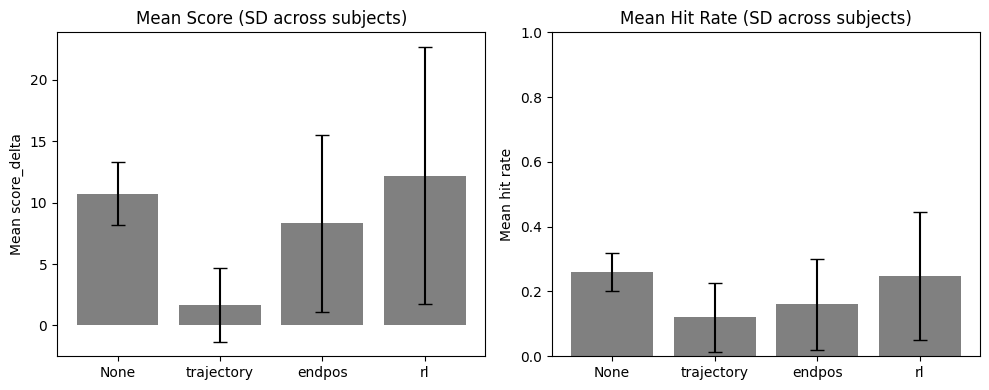

In [6]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

subjects = ["sub1", "sub2", "sub3"]
base_dir = "output"

paths = [f"output/{sub}/trial_log.csv" for sub in subjects]


dfs = []
for i, p in enumerate(paths, start=1):
    if os.path.exists(p):
        d = pd.read_csv(p)
        d["subject_id"] = f"sub{i}"
        dfs.append(d)

df = pd.concat(dfs, ignore_index=True)

order = ["None", "trajectory", "endpos", "rl"]
df["feedback_type"] = df["feedback_type"].fillna("None").replace({None: "None"})
df["feedback_type"] = df["feedback_type"].astype(str)

sub_stats = (
    df.groupby(["subject_id", "feedback_type"], as_index=False)
      .agg(mean_hit=("hit", "mean"),
           mean_score=("score_delta", "mean"))
)

g = sub_stats.groupby("feedback_type")
mean_score = g["mean_score"].mean().reindex(order)
std_score  = g["mean_score"].std(ddof=1).reindex(order)

mean_hit = g["mean_hit"].mean().reindex(order)
std_hit  = g["mean_hit"].std(ddof=1).reindex(order)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(mean_score.index, mean_score.values, yerr=std_score.values, capsize=5, color="gray")
ax[0].set_ylabel("Mean score_delta")
ax[0].set_title("Mean Score (SD across subjects)")

ax[1].bar(mean_hit.index, mean_hit.values, yerr=std_hit.values, capsize=5, color="gray")
ax[1].set_ylabel("Mean hit rate")
ax[1].set_ylim(0, 1)
ax[1].set_title("Mean Hit Rate (SD across subjects)")

plt.tight_layout()
plt.show()


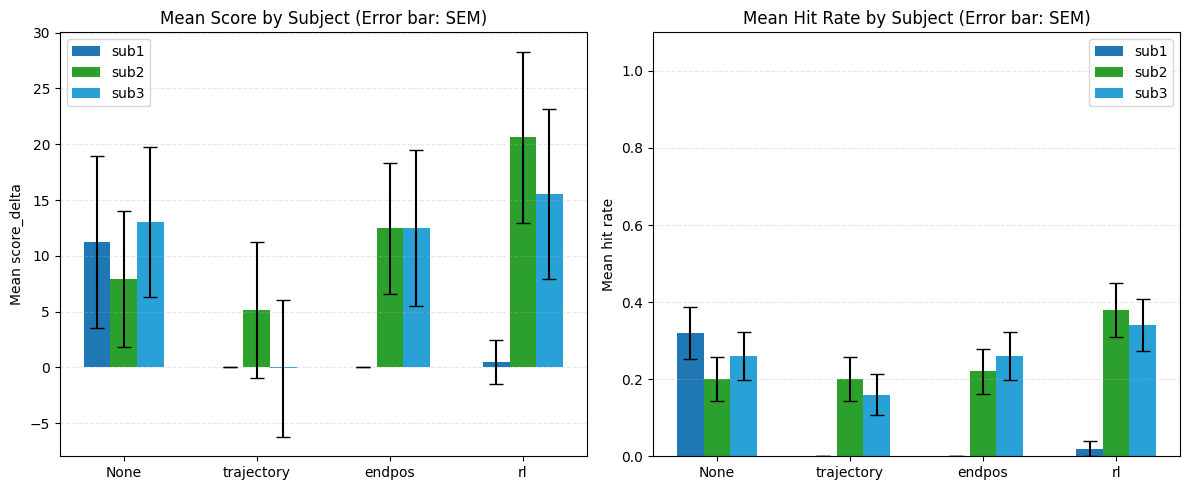

In [7]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#2ca02c', "#27a1d6"] 

# Ensure paths is defined if run independently (fallback, though usually defined in previous cell)
if 'paths' not in locals() and 'paths' not in globals():
     # Fallback or error hint
     print("Warning: 'paths' variable not found. Please run the previous cell defining 'paths'.")
     paths = []

dfs = []
for i, p in enumerate(paths, start=1):
    if os.path.exists(p):
        d = pd.read_csv(p)
        d["subject_id"] = f"sub{i}"
        dfs.append(d)

if not dfs:
    print("No data found. Please run the game to generate trial logs.")
else:
    df = pd.concat(dfs, ignore_index=True)

    order = ["None", "trajectory", "endpos", "rl"]
    df["feedback_type"] = df["feedback_type"].fillna("None").replace({None: "None"})
    df["feedback_type"] = df["feedback_type"].astype(str)

    # Calculate Mean and SEM (Standard Error of Mean) across trials for each subject
    sub_stats = (
        df.groupby(["subject_id", "feedback_type"], as_index=False)
        .agg(
            mean_hit=("hit", "mean"),
            err_hit=("hit", "sem"),
            mean_score=("score_delta", "mean"),
            err_score=("score_delta", "sem")
        )
    )

    # Grouped Bar Chart Settings
    subjects = sorted(sub_stats["subject_id"].unique())
    x = np.arange(len(order))
    
    # Adjust bar width to increase spacing between groups
    # A smaller total_group_width means larger gaps between groups
    total_group_width = 0.6  # Occupy 60% of the space (Gap = 40%)
    width = total_group_width / len(subjects)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for i, sub in enumerate(subjects):
        # Filter data for current subject
        sub_data = sub_stats[sub_stats["subject_id"] == sub].set_index("feedback_type").reindex(order)
        
        # Calculate offset to group bars (center them around tick)
        offset = (i - len(subjects)/2 + 0.5) * width
        
        # Safe color selection
        col = colors[i % len(colors)]
        
        ax[0].bar(x + offset, sub_data["mean_score"], width, label=sub, color=col,
                 yerr=sub_data["err_score"], capsize=5)
        ax[1].bar(x + offset, sub_data["mean_hit"], width, label=sub, color=col,
                 yerr=sub_data["err_hit"], capsize=5)

    # Formatting axes
    for a in ax:
        a.set_xticks(x)
        a.set_xticklabels(order)
        a.legend()
        a.grid(axis='y', linestyle='--', alpha=0.3)

    ax[0].set_ylabel("Mean score_delta")
    ax[0].set_title("Mean Score by Subject (Error bar: SEM)")

    ax[1].set_ylabel("Mean hit rate")
    ax[1].set_ylim(0, 1.1)
    ax[1].set_title("Mean Hit Rate by Subject (Error bar: SEM)")

    plt.tight_layout()
    plt.show()

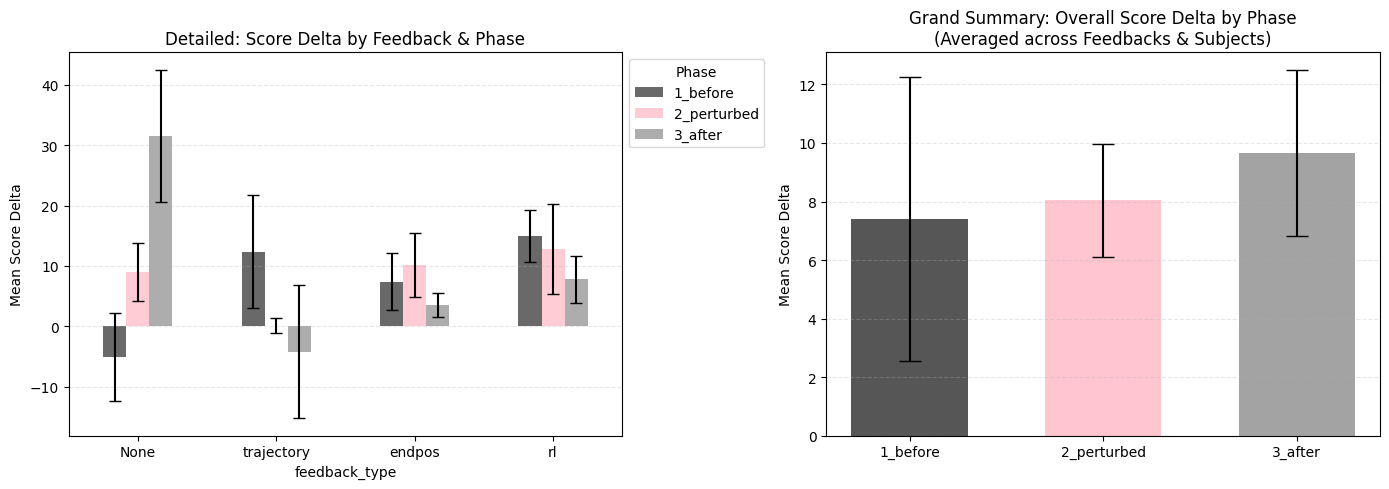

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

subjects = ["sub1", "sub2", "sub3"]
paths = [f"output/{sub}/trial_log.csv" for sub in subjects]

dfs = []
for sub, file in zip(subjects, paths):
    if os.path.exists(file):
        df = pd.read_csv(file)
        df['subject'] = sub
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df.sort_values(['subject', 'block_id'])
combined_df['feedback_type'] = combined_df['feedback_type'].fillna("None")

combined_df['block_order'] = combined_df.groupby(['subject', 'feedback_type'])['block_id'].rank(method='dense')

phase_map = {
    1.0: '1_before',   # before perturbation (False)
    2.0: '2_perturbed', # during perturbation (True)
    3.0: '3_after'     # after perturbation (False)
}
combined_df['phase_name'] = combined_df['block_order'].map(phase_map)
combined_df.columns = combined_df.columns.str.strip()

feedback_order = ['None', 'trajectory', 'endpos', 'rl']

# 1. Detailed View: Score_delta by Feedback x Phase
subject_means_phase = (
    combined_df.groupby(['subject', 'feedback_type', 'phase_name'])['score_delta']
    .mean()
    .reset_index()
)
df_phases = (
    subject_means_phase.groupby(['feedback_type', 'phase_name'])['score_delta']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'mean_score_delta', 'sem': 'se_score_delta'})
)
# sorting
df_phases['feedback_type'] = pd.Categorical(df_phases['feedback_type'], categories=feedback_order, ordered=True)
df_phases = df_phases.sort_values(['feedback_type', 'phase_name'])

df_phases.to_csv("output/combined_score_delta_correct_phases.csv", index=False)


# 2. Overall Summary: Score_delta by Phase (Merged across Feedback Types)
# First, average across all feedback types for each subject & phase
subject_means_overall = (
    combined_df.groupby(['subject', 'phase_name'])['score_delta']
    .mean()
    .reset_index()
)

# Then, calculate grand mean and SEM across subjects
df_summary = (
    subject_means_overall.groupby(['phase_name'])['score_delta']
    .agg(['mean', 'sem'])
    .reset_index()
    .rename(columns={'mean': 'mean_score_delta', 'sem': 'se_score_delta'})
)

# print("=== Overall Phase Summary (Merged Feedbacks) ===")
# print(df_summary)
df_summary.to_csv("output/overall_phase_summary.csv", index=False)


# === Plotting ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Detailed Breakdown (Feedback x Phase)
pivot_phases_mean = df_phases.pivot(index='feedback_type', columns='phase_name', values='mean_score_delta').reindex(feedback_order)
pivot_phases_se = df_phases.pivot(index='feedback_type', columns='phase_name', values='se_score_delta').reindex(feedback_order)

pivot_phases_mean.plot(kind='bar', yerr=pivot_phases_se, capsize=4, ax=axes[0], color=['#444444', 'pink', '#999999'], alpha=0.8, rot=0)
axes[0].set_title("Detailed: Score Delta by Feedback & Phase")
axes[0].set_ylabel("Mean Score Delta")
axes[0].legend(title="Phase", bbox_to_anchor=(1.0, 1), loc='upper left')
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# Plot 2: Overall Phase Effect (Merged Feedback)
phases = df_summary['phase_name']
means = df_summary['mean_score_delta']
sems = df_summary['se_score_delta']


axes[1].bar(phases, means, yerr=sems, capsize=8, color=['#444444', 'pink', '#999999'], alpha=0.9, width=0.6)
axes[1].set_title("Grand Summary: Overall Score Delta by Phase\n(Averaged across Feedbacks & Subjects)")
axes[1].set_ylabel("Mean Score Delta")
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

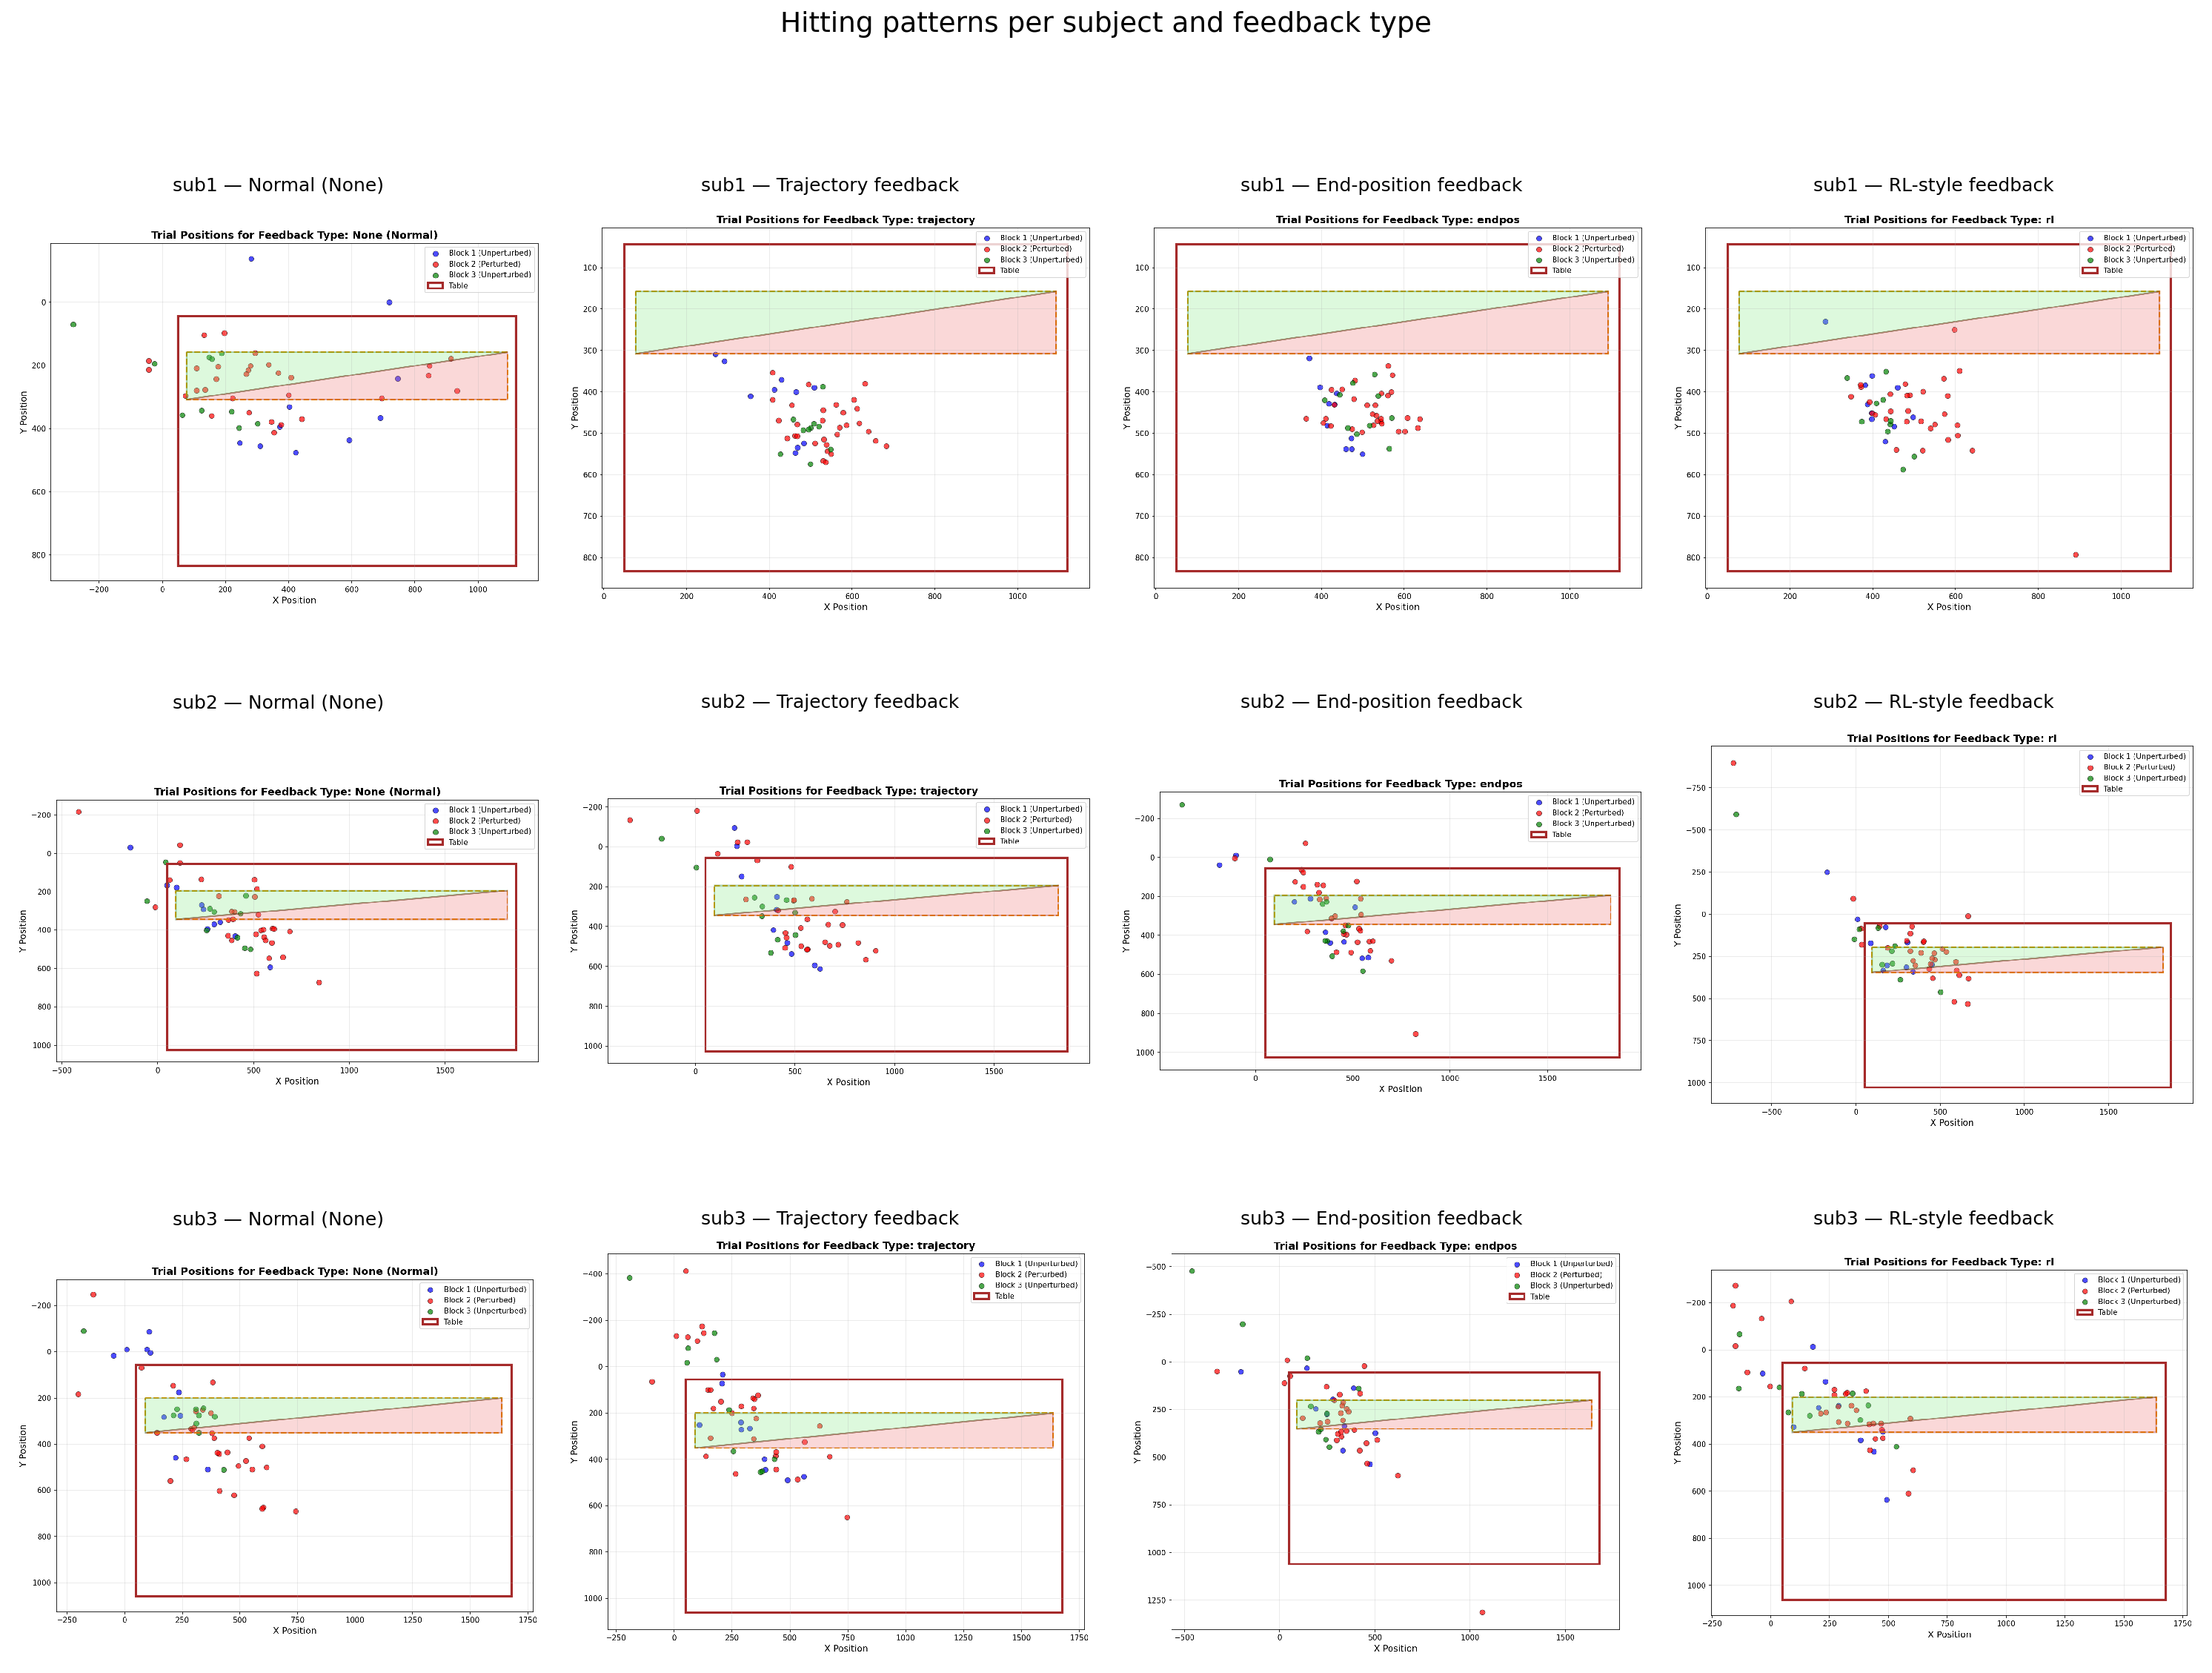

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

feedbacks = [
    ("normal", "Normal (None)"),
    ("trajectory", "Trajectory feedback"),
    ("endpos", "End-position feedback"),
    ("rl", "RL-style feedback"),
]


fig, axes = plt.subplots(len(subjects), len(feedbacks), figsize=(20, 16), dpi=150)

for r, sub in enumerate(subjects):
    for c, (key, title) in enumerate(feedbacks):
        ax = axes[r, c]
        path = os.path.join(base_dir, sub, f"hitting_pattern_{key}.png")
        if os.path.exists(path):
            ax.imshow(mpimg.imread(path), interpolation='nearest')
        ax.axis("off")
        ax.set_title(f"{sub} — {title}", fontsize=12)

fig.suptitle("Hitting patterns per subject and feedback type", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("results.png", dpi=300)
plt.show()


---
## Task 3

1. *What’s the effect on subject’s performance of each feedback_type*

We observed that a shared pattern for both mean score deltas and hit rates: `rl` > `endpos` > `trajectory`, i.e.,  `rl` reached the best performance, followed by `endpos`, and then `trajectory`. Specifically, performance under `rl` feedback showed similar level with `none` feedback.

The reason for the results migh be:
- **The cognitive load**: Compared to `trajectory`, `endpos` and `rl` feedback provides less visual information about the full movement. Excessive visual information might lead to reliance on external feedback and subjects' attempting to follow the exact path. As a result, subjects might perform worse under `trajectory` feedback, but better under `endpos` and `rl` feedback. 
- **The sequential learning effect**: Interestingly, `rl` feedback does not provide any positional information about the movement, yet subjects still performed best under this condition. Besides the cognitive load explanation, another possible reason is the sequential learning effect, as `rl` feedback block is always the last block, subjects might have learned the most by then.

2. *Under which feedback_type was your subject able to adapt the best?*

Just by visual inspection of the hitting-pattern plots, we consider **`endpos`** and **`rl`** to show the best adaptation in our experiment. Under the rightward perturbation force, both feedback types shows endpoints distributions that are *right departure* (red), with some endpoints close to the baseline direction (blue) due to adaptation. Moreover, after removing the perturbation, we can see an aftereffect: the endpoints in the later-perturbed phase (green) appear to shift *slightly leftward*, consistent with residual compensation learned during perturbation. 

However, this conclusion is **qualitative** and based on **naked-eye inspection** only; it may be imprecise without a quantitative error metric or within-block learning curves.

We suggest two main reasons:
- **Task-relevant / low-load feedback:** `endpos` and `rl` provide simpler, more task-relevant feedback than `trajectory`. `endpos` directly informs the final outcome, while `rl` provides a clear success/failure signal that may encourage a stable correction strategy, rather than over-focusing on the full trajectory shape and bring more cognitive load.
- **Sequential (order) effects:** The apparent advantage may also reflect practice effects due to block order: as the experiment progresses, subjects may gradually gain skill and familiarity with the task, which can inflate performance in later blocks.


---
## Task 4

Here we swapped the order of `endpos` and `rl` feedback conditions in the block structure, to see if the **sequential learning effect** influenced the results.

It showed that the mean score delta and hit rate under `endpos` feedback were now higher than those under `rl` feedback, indicating that `endpos` feedback enabled better adaptation than `rl` feedback when it was presented later in the sequence. 

This suggests that the sequential learning effect did play a role in the previous results, where `rl` feedback was always last.

> Currently only one subject has been tested under this modified protocol. More subjects are needed to confirm this finding.

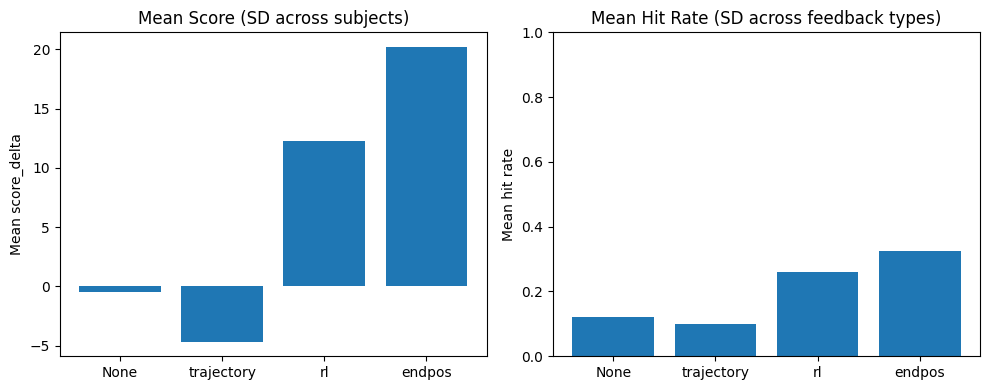

In [ ]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("output/sub2_2/trial_log.csv")


order = ["None", "trajectory",  "rl", "endpos"]
df["feedback_type"] = df["feedback_type"].fillna("None").replace({None: "None"})
df["feedback_type"] = df["feedback_type"].astype(str)

sub_stats = (
    df.groupby(["feedback_type"], as_index=False)
      .agg(mean_hit=("hit", "mean"),
           mean_score=("score_delta", "mean"))
)

g = sub_stats.groupby("feedback_type")
mean_score = g["mean_score"].mean().reindex(order)
std_score  = g["mean_score"].std(ddof=1).reindex(order)

mean_hit = g["mean_hit"].mean().reindex(order)
std_hit  = g["mean_hit"].std(ddof=1).reindex(order)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(mean_score.index, mean_score.values, yerr=std_score.values, capsize=5)
ax[0].set_ylabel("Mean score_delta")
ax[0].set_title("Mean Score")

ax[1].bar(mean_hit.index, mean_hit.values, yerr=std_hit.values, capsize=5)
ax[1].set_ylabel("Mean hit rate")
ax[1].set_ylim(0, 1)
ax[1].set_title("Mean Hit Rate")

plt.tight_layout()
plt.show()
